# Import Data

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import warnings
 
warnings.filterwarnings(action='ignore')

In [2]:
# import the data
fake_news = pd.read_csv("/Users/elliehuang/Desktop/pstat_134/archive (1)/Fake.csv")
true_news = pd.read_csv("/Users/elliehuang/Desktop/pstat_134/archive (1)/True.csv")

# view first few rows for each 
print(fake_news.head())
print(true_news.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

In [3]:
# add labels
fake_news["label"] = "Fake"
true_news["label"] = "True"

# combine the two separate dataframes
news_df = pd.concat([fake_news, true_news], ignore_index = True)

# Data Cleaning


In [4]:
import string

# checking for missing values
print(news_df.isna().sum())

# converting letters to lowercase
news_df["title"] = news_df["title"].str.lower()
news_df["text"] = news_df["text"].str.lower()

# removing punctuation
news_df["title"] = news_df["title"].str.replace("[{}]".format(string.punctuation), "", regex = True)
news_df["text"] = news_df["text"].str.replace("[{}]".format(string.punctuation), "", regex = True)

# removing other special characters
news_df["title"] = news_df["title"].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8"))
news_df["text"] = news_df["text"].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8"))

# view cleaned dataset
print(news_df.head())

title      0
text       0
subject    0
date       0
label      0
dtype: int64
                                               title  \
0   donald trump sends out embarrassing new years...   
1   drunk bragging trump staffer started russian ...   
2   sheriff david clarke becomes an internet joke...   
3   trump is so obsessed he even has obamas name ...   
4   pope francis just called out donald trump dur...   

                                                text subject  \
0  donald trump just couldn t wish all americans ...    News   
1  house intelligence committee chairman devin nu...    News   
2  on friday it was revealed that former milwauke...    News   
3  on christmas day donald trump announced that h...    News   
4  pope francis used his annual christmas day mes...    News   

                date label  
0  December 31, 2017  Fake  
1  December 31, 2017  Fake  
2  December 30, 2017  Fake  
3  December 29, 2017  Fake  
4  December 25, 2017  Fake  


In [5]:
import nltk

# tokenizing article text into words
tokenized_news = [nltk.word_tokenize(article) for article in news_df["text"]]

In [6]:
from nltk.corpus import stopwords

# removing stopwords
stop_words = set(stopwords.words("english"))

cleaned_articles = [[word for word in article if word not in stop_words] 
    for article in tokenized_news]

news_df["text"] = [" ".join(article) for article in cleaned_articles]
print((news_df["text"].head()))

0    donald trump wish americans happy new year lea...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: text, dtype: object


# EDA


Most common words overall 

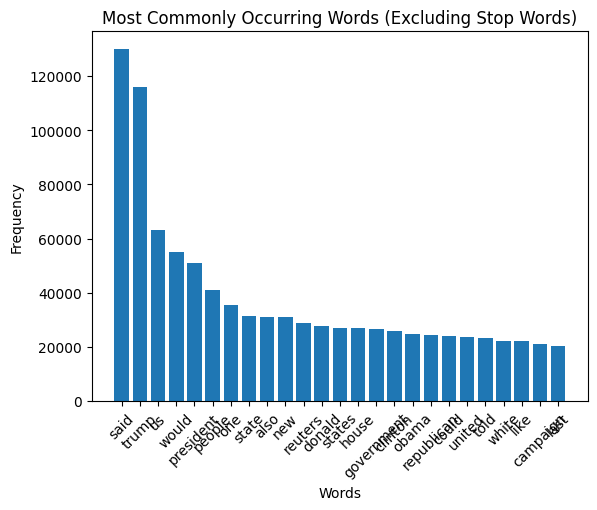

In [7]:
from collections import Counter
all_words = [word for article in cleaned_articles for word in article]
word_counts = Counter(all_words)

common_words = word_counts.most_common(25) 
words, counts = zip(*common_words)

plt.figure()
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Commonly Occurring Words (Excluding Stop Words)")
plt.xticks(rotation = 45)
plt.show()

Most common words in fake vs. true articles

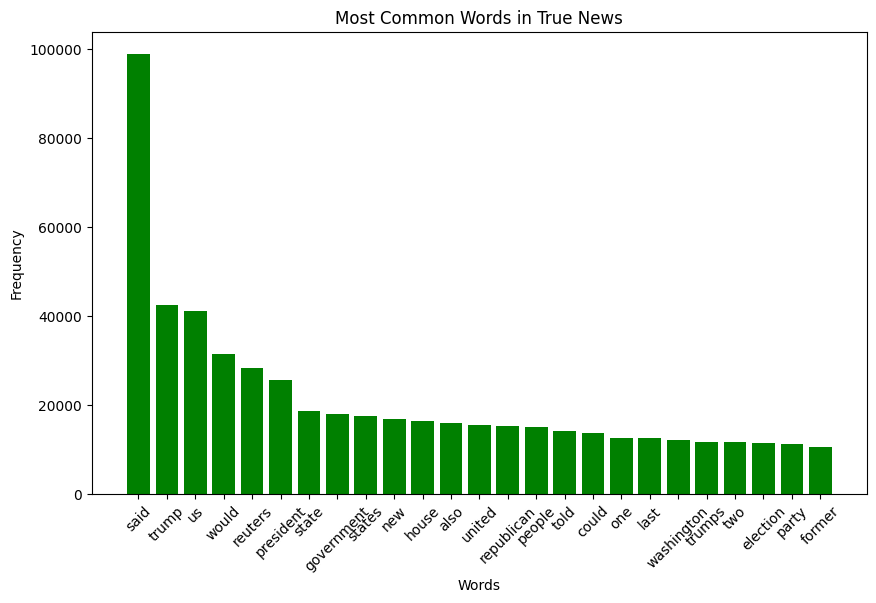

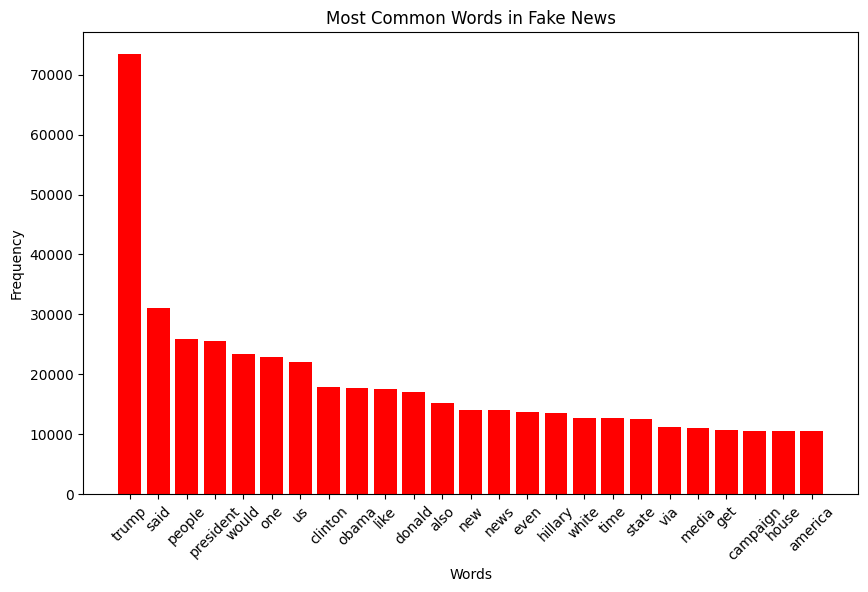

In [8]:
fake_articles = news_df[news_df.label == "Fake"]
fake_tokenized = [nltk.word_tokenize(article) for article in fake_articles["text"]]
fake_cleaned = [[word for word in article if word not in stop_words] 
    for article in fake_tokenized]
fake_words = [word for article in fake_cleaned for word in article]

true_articles = news_df[news_df.label == "True"]
true_tokenized = [nltk.word_tokenize(article) for article in true_articles["text"]]
true_cleaned = [[word for word in article if word not in stop_words] 
    for article in true_tokenized]
true_words = [word for article in true_cleaned for word in article]

fake_word_counts = Counter(fake_words)
true_word_counts = Counter(true_words)

fake_most_common = fake_word_counts.most_common(25) 
fake_words, fake_counts = zip(*fake_most_common)
true_most_common = true_word_counts.most_common(25) 
true_words, true_counts = zip(*true_most_common)

plt.close("all")

# plotting most common words in true articles
plt.figure(figsize = (10, 6))
plt.bar(true_words, true_counts, color="green")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in True News")
plt.xticks(rotation = 45)
plt.show()

# plotting most common words in fake articles
plt.figure(figsize = (10, 6))
plt.bar(fake_words, fake_counts, color="red")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Fake News")
plt.xticks(rotation = 45)
plt.show()

From the above graphs, we can see the difference in the most common words for fake vs. true news articles. "Election," "republican," "house," "reuters," and "could" seem to be more common in the true news. Meanwhile, "clinton," "obama," "donald," "white," "media," and "campaign" seem to be more common in the fake news. 

Creating a wordcloud

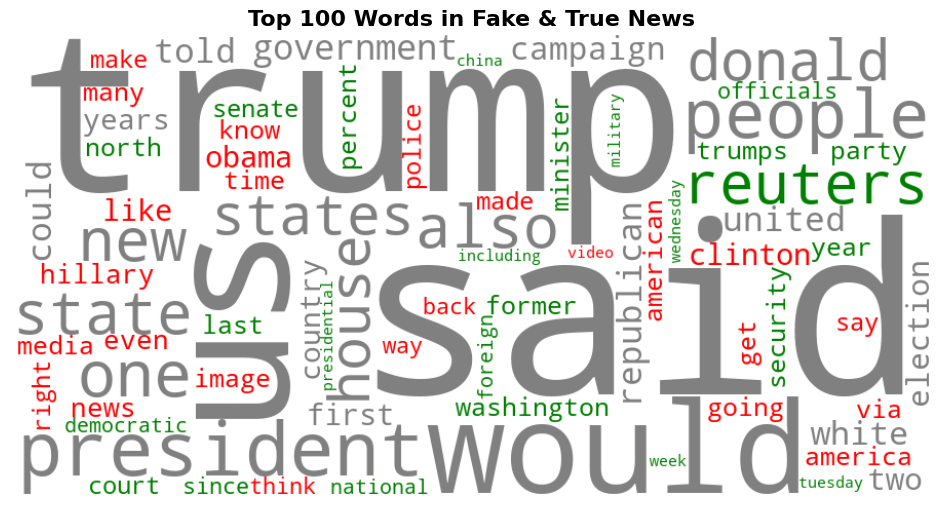

In [17]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import Word

# create dictionaries for word frequencies
fake_top_words = dict(fake_word_counts.most_common(50))
true_top_words = dict(true_word_counts.most_common(50))

# merge word counts while keeping track of origins
combined_word_counts = {word: fake_top_words.get(word, 0) + true_top_words.get(word, 0)
                        for word in set(fake_top_words) | set(true_top_words)}

# custom function to color words based on their origin
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in fake_top_words and word in true_top_words:
        return "rgb(128, 128, 128)"  # gray for shared words
    elif word in fake_top_words:
        return "rgb(255, 0, 0)"  # red for fake news words
    elif word in true_top_words:
        return "rgb(0, 128, 0)"  # green for true news words
    return "rgb(0, 0, 0)"  

# generate word cloud
wordcloud = WordCloud(
    width = 900, height = 450, max_words = 100, background_color = "white"
).generate_from_frequencies(combined_word_counts)

# apply custom coloring 
wordcloud.recolor(color_func = color_func)
 
# plotting the wordcloud
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Top 100 Words in Fake & True News", fontsize = 16, fontweight = "bold")
plt.show()

Finding the most common bigrams within the text:

In [10]:
from nltk.util import bigrams

def extract_bigrams(text):
    words = [word for word in nltk.word_tokenize(text.lower()) if word.isalnum() and word not in stop_words]
    return list(bigrams(words))

# Extract bigrams from each review
all_bigrams = []
for article in news_df["text"]:
    all_bigrams.extend(extract_bigrams(article))

# Convert bigrams to string format
bigram_strings = [" ".join(bigram) for bigram in all_bigrams]

# Count bigrams
bigram_counts = Counter(bigram_strings)

# Get top 30 bigrams
top_bigrams = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])
print(top_bigrams.head())

            bigram  count
0     donald trump  21047
1    united states  18354
2      white house  14571
3  hillary clinton   8864
4         new york   8515


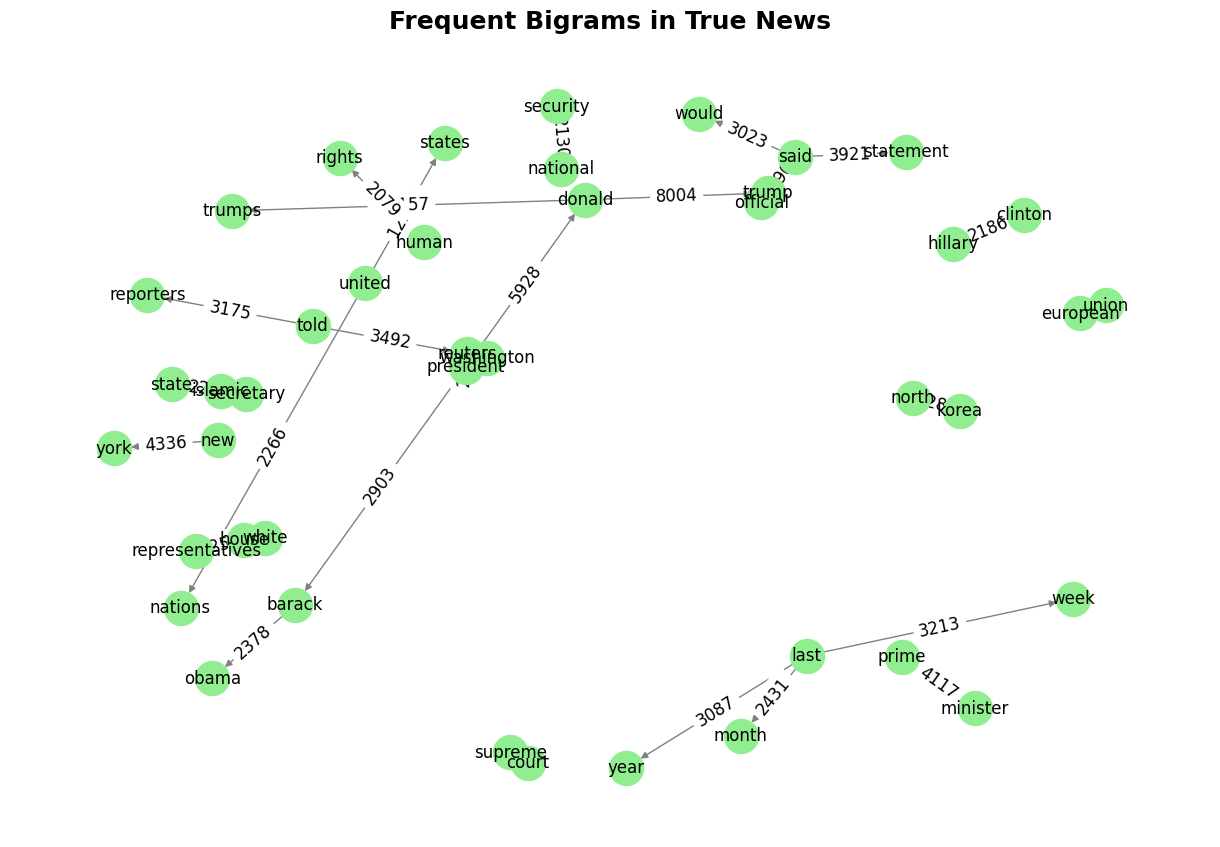

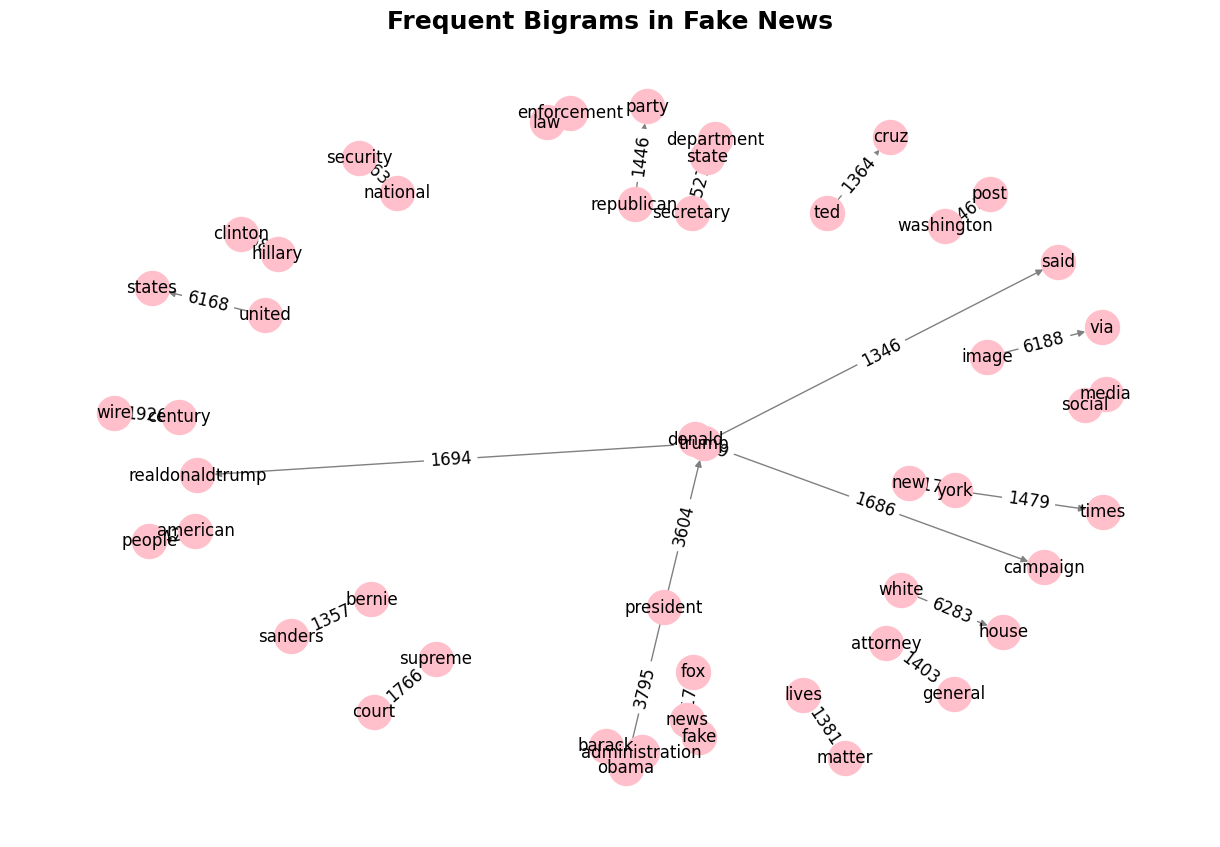

In [13]:
from itertools import islice
import networkx as nx
from nltk.tokenize import word_tokenize

# function to process bigrams

def get_top_bigrams(df, label, top_n = 30):
    stop_words = set(stopwords.words('english'))
    
    df = df[df['label'] == label]
    
    bigrams = []
    for text in df['text'].dropna():  # remove na values
        words = [word.lower() for word in word_tokenize(str(text)) if word.isalpha()]
        words = [word for word in words if word not in stop_words and len(word) > 2]  # remove stopwords
        bigrams.extend(zip(words, islice(words, 1, None)))  # create bigrams
        
    bigram_counts = Counter(bigrams)
    
    # select only the top n bigrams
    top_bigrams = dict(bigram_counts.most_common(top_n))
    
    return top_bigrams

# get top 30 bigrams for TRUE and FAKE news
true_bigrams = get_top_bigrams(news_df, "True", top_n=30)
fake_bigrams = get_top_bigrams(news_df, "Fake", top_n=30)

# function to plot bigram graph
def plot_bigram_graph(bigrams, title, color):
    G = nx.DiGraph()
    
    for (word1, word2), count in bigrams.items():
        G.add_edge(word1, word2, weight = count)
    
    plt.figure(figsize = (12, 8))
    pos = nx.spring_layout(G, k = 1.5) 
    edges = G.edges(data = True)
    
    nx.draw(G, pos, node_color = color, edge_color = 'gray', with_labels = True, 
            node_size = 600, font_size = 12) 
    
    # draw edge labels (weights)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in edges}, 
                                 font_size = 12) 
    
    plt.title(title, fontsize = 18, fontweight = "bold") 
    plt.show()

# plot true news bigram graph
plot_bigram_graph(true_bigrams, "Frequent Bigrams in True News", color = "lightgreen")

# plot fake news bigram graph
plot_bigram_graph(fake_bigrams, "Frequent Bigrams in Fake News", color = "pink")

The true news bigram graph features terms such as "state secretary", "national security", "prime minister", and "human rights," suggesting coverage of political events, government policies, and international affairs. The presence of "donald trump", "barack obama", and "hillary clinton" indicates reporting on prominent political figures. Additionally, "united states", "north korea", and "european union" point to coverage of global geopolitics. Overall, the true news bigram graph a structured and distributed network with central terms related to governance and diplomacy.

In contrast, the fake news bigram graph displays a looser, more fragmented structure with clusters. The frequent occurrence of "fake news", "media social", and "realdonald trump" suggests possible misinformation and social media discourse. This network includes "bernie sanders", "ted cruz", and "campaign", indicating a focus on less prominent political figures. Additionally, phrases like "attorney general", "supreme court", and "law enforcement" display that legal and judicial topics are common.

Pre-processing for model training:

In [32]:
# tokenization
corpus = news_df["text"]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# load GloVe embeddings
def load_glove_embeddings(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix

embedding_dim = 50
embedding_matrix = load_glove_embeddings('/Users/elliehuang/Desktop/pstat_134/FinalProject/glove.6B/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

# convert text to embedding representation
def text_to_embedding(text, tokenizer, embedding_matrix, embedding_dim):
    words = text.split()
    word_indices = [tokenizer.word_index[word] for word in words if word in tokenizer.word_index]
    
    if len(word_indices) == 0:
        return np.zeros(embedding_dim)  # return zero vector if no words found
    
    # average word embeddings
    embeddings = np.array([embedding_matrix[idx] for idx in word_indices])
    return np.mean(embeddings, axis=0)

X = np.array([text_to_embedding(text, tokenizer, embedding_matrix, embedding_dim) for text in corpus])

# encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(news_df["label"])
print(label_encoder.classes_)  

['Fake' 'True']


Training a Logistic Regession model:

In [33]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

# train a Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)  # Set high iterations to ensure convergence
log_reg_model.fit(X_train, y_train)

# make predictions
y_pred_log_reg = log_reg_model.predict(X_test)

# evaluate model performance
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")

# convert predictions back to original labels
y_pred_labels_log_reg = label_encoder.inverse_transform(y_pred_log_reg)
print("Predicted Labels:", y_pred_labels_log_reg)


Logistic Regression Accuracy: 0.9218
Predicted Labels: ['Fake' 'Fake' 'True' ... 'True' 'True' 'Fake']


Training a Support Vector Machine (SVM) model:

In [34]:
# train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# make predictions
y_pred = svm_model.predict(X_test)
y_pred_labels_svm = label_encoder.inverse_transform(y_pred)

# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Predicted Labels:", y_pred_labels_svm)

Accuracy: 0.9239
Predicted Labels: ['Fake' 'Fake' 'True' ... 'True' 'True' 'Fake']
